<a href="https://colab.research.google.com/github/porhJ/UAV-Suspended-Load-Control/blob/main/perfect_drone_dance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

In [ ]:
from scipy.linalg import solve_continuous_are

$\underline q$ = $[x, z, \theta_d, \theta_p]$

# Simple case

- y = x
- no delay, friction

im gonna finish this rq, trust me

starting time: 13:11

In [ ]:
class PackagingDroneSimple():
  def __init__(self, m_d, m_p, Id_cm, r_d, l, x_ref_, u_ref_, g = 9.8):
    self.m_d = m_d
    self.Id_cm = Id_cm
    self.r_d = r_d
    self.m_p = m_p
    self.l = l
    self.x_ref_ = x_ref_
    self.dx_ref_ = np.array([0, 0, 0, 0])
    self.u_ref_ = u_ref_
    self.g = g

  def dynamics(self, x_, u_):
    x, dx, z, dz, theta_d, dtheta_d, theta_p, dtheta_p = x_

    # frm M * ddq + C * dq = tau_g + Bu
    # its actually just newton's 2nd law but fancy
    # M is mass matrix (or intertia if it is in theta coordinate)
    # Thus force = tau_g + Bu - C * dq
    # So F = Ma where a is obviously ddq
    # tau_g + Bu - C * dq = M * ddq

    M = np.array([[self.m_p + self.m_d, 0, 0, self.m_p * self.l * np.cos(theta_p)],
                  [0, self.m_p + self.m_d, 0, self.m_p * self.l * np.sin(theta_p)],
                  [0, 0, self.Id_cm, 0],
                  [self.m_p * self.l * np.cos(theta_p), self.m_p * self.l * np.sin(theta_p), 0, self.m_p * (self.l ** 2)]])

    C = np.array([[0, 0, 0, -self.l * dtheta_p * np.sin(theta_p)],
                  [0, 0, 0, self.l * dtheta_p * np.cos(theta_p)],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]])

    tau_g = np.array([[0, -(self.m_p + self.m_d) * self.g, 0, -self.m_p * self.g * self.l * np.sin(theta_p)]])
    tau_g = tau_g.T
    B = np.array([[np.cos(theta_d), np.cos(theta_d)],
                  [np.sin(theta_d), np.sin(theta_d)],
                  [self.r_d, -self.r_d],
                  [0, 0]])

    q_dot = np.array([[dx, dz, dtheta_d, dtheta_p]])
    q_dot = q_dot.T

    force = tau_g + B @ u_ - C @ q_dot
    # we want ddq, thus we use inv(M), but this is lowkey unsafe, so we just gonna use np.linalg.solve, it is safer. source: trust me bro
    ddq = np.linalg.solve(M, force).flatten()
    ddx, ddz, ddtheta_d, ddtheta_p = ddq

    # we gonna return dx_
    return np.array([dx, ddx, dz, ddz, dtheta_d, ddtheta_d, dtheta_p, ddtheta_p])

  def get_jacobian(self, eps = 1e-6):
    n = len(self.x_ref_)
    m = 2
    A = np.zeros((n, n))
    B = np.zeros((n, m))
    f0 = self.dynamics(self.x_ref_, self.u_ref_)

    for i in range(n):
      y_perturb = self.x_ref_.copy()
      y_perturb[i] += eps
      f_perturb = self.dynamics(y_perturb, self.u_ref_)
      A[:, i] = (f_perturb - f0) / eps

    for j in range(m):
      u_perturb = self.u_ref_.copy()
      u_perturb[j] += eps
      f_perturb_u = self.dynamics(self.x_ref_, u_perturb)
      B[:, j] = (f_perturb_u - f0) / eps

    return A, B

  def linearized_dynamics(self, x_, u_, A, B):
    delta_x_ = x_ - self.x_ref_
    delta_u_ = u_ - self.u_ref_
    delta_dx_ = A @ delta_x_ + B @ delta_u_
    dx_ = self.dx_ref_ + delta_dx_
    return dx_

  def control_law(self, x_, int_, kr_, ki_):
    error_x = (x_ - self.x_ref_).reshape(-1, 1)
    error_int = int_.reshape(-1, 1)
    delta_u = - kr_ @ error_x + ki_ @ error_int
    return self.u_ref_ + delta_u

  def get_kr_ (self, A, B, Q, R):
    P = solve_continuous_are(A, B, Q, R)
    return np.linalg.inv(R) @ B.T @ P

  def step(self, x_, kr_, ki_ , A, B, int_, dt = 1.0e-3):
    int_ += (self.x_ref_ - x_) * dt
    u_ = self.control_law(x_, int_, kr_, ki_)
    dx_ = self.dynamics(x_, u_)
    return x_ + dx_ * dt, int_

In [ ]:
m_d = 5
m_p = 2
M = m_d + m_p
g = 9.8
r_d = 0.5
Id_cm = 1/12 * m_d * (2 * r_d) ** 2
l = 1.5
x_ref = 10
z_ref = 5
x_ref_ = np.array([x_ref, 0, z_ref, 0, 0.5 * np.pi, 0, 0, 0])
u_ref_ = np.array([[0.5 * M * g, 0.5 * M * g]])
u_ref_ = u_ref_.T
ki_ = np.array([[1.0, 0, 5, 0, 0, 0, 0, 0],
                [1.0, 0, 5, 0, 0, 0, 0, 0]])
int_ = 0

$x_{ref} = [x, \dot{x}, z, \dot{z}, \theta_d, \dot{\theta_d}, \theta_p, \dot{\theta_p}]$

In [ ]:
Q = np.diag([20, 1, 5, 1, 50, 1, 50, 1])
R = np.diag([0.01, 0.01])

In [ ]:
pkgDroneSys = PackagingDroneSimple(m_d, m_p, Id_cm, r_d, l, x_ref_,  u_ref_)

In [ ]:
A, B = pkgDroneSys.get_jacobian()

In [ ]:
Kr = pkgDroneSys.get_kr_(A, B, Q, R)

In [ ]:
x_ = np.array([0, 0, 2, 0, np.pi - 1.0e-3, 0, 0 + 1.0e-3, 0])

In [ ]:
int_ = 0

In [ ]:
hist = []

In [ ]:
x_hist = []
dx_hist = []
z_hist = []
dz_hist = []
theta_d_hist = []
dtheta_d_hist = []
theta_p_hist = []
dtheta_p_hist = []

In [ ]:
# x_hist, dx_hist, z_hist, dz_hist, theta_d_hist, dtheta_d_hist, theta_p_hist, dtheta_p_hist

In [ ]:
t_terminate = 0

In [ ]:
for step in range(20000):
  x_, int_ = pkgDroneSys.step(x_, Kr, ki_, A, B, int_)
  hist.append(x_)
  x, dx, z, dz, theta_d, dtheta_d, theta_p, dtheta_p = x_
  theta_d = np.arctan2(np.sin(theta_d), np.cos(theta_d))
  theta_p = np.arctan2(np.sin(theta_p), np.cos(theta_p))
  x_hist.append(x)
  dx_hist.append(dx)
  z_hist.append(z)
  dz_hist.append(dz)
  theta_d_hist.append(theta_d)
  dtheta_d_hist.append(dtheta_d)
  theta_p_hist.append(theta_p)
  dtheta_p_hist.append(dtheta_p)
  if abs(x - x_ref) < 0.5 and abs(z - z_ref) < 0.5 :
    t_terminate = step

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
x_ref_

array([10.        ,  0.        ,  5.        ,  0.        ,  1.57079633,
        0.        ,  0.        ,  0.        ])

In [ ]:
def plot_drone_LQR(
    states, t_terminate, Q, R
):
    fig, ax = plt.subplots(figsize=(12, 8))
    for state_name, state in states.items():
      state_hist, state_eq = state
      plt.plot(state_hist, label=f"{state_name}")
      plt.axhline(y=state_eq, linestyle="--", label=f"{state_name} equilibrium at {state_eq}")
    plt.title("Inverted Pendulum LQR-Control")
    plt.axvline(
        x=t_terminate, color="g", linestyle="--", label=f"Reach final point time (x={t_terminate})"
    )
    fig = plt.gcf()
    fig.text(
        0.5,
        0.005,
        f"Q = diag({np.diag(Q)})    R = diag({np.diag(R)})",
        ha="center",
        va="bottom",
        fontsize=9,
    )
    plt.xlabel("Time Steps")
    plt.legend()
    Q_vals = "_".join(f"{v:g}" for v in np.diag(Q))
    R_vals = "_".join(f"{v:g}" for v in np.diag(R))

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.figtext(0.5, 0.01, "Q = diag(...)  R = diag(...)", ha="center", fontsize=10)
    plt.subplots_adjust(right=0.75, bottom=0.15)
    plt.show()

In [ ]:
states_hist = [x_hist, dx_hist, z_hist, dz_hist, theta_d_hist, dtheta_d_hist, theta_p_hist, dtheta_p_hist]

In [ ]:
states_name = ["x", "dx", "z", "dz", "theta_d", "dtheta_d", "theta_p", "dtheta_p"]

In [ ]:
states = {}

In [ ]:
n = len(states_hist)
for i in range(n):
  states[f"{states_name[i]}"] = [states_hist[i], x_ref_[i]]

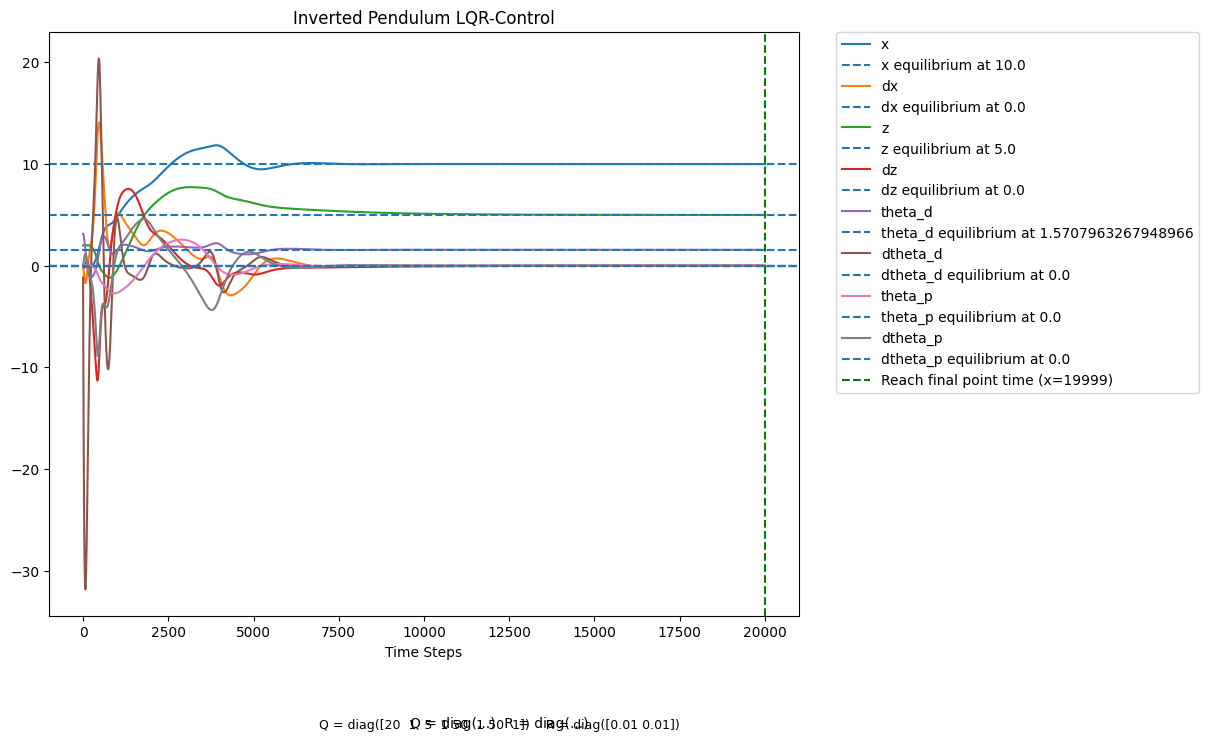

In [ ]:
plot_drone_LQR(states, t_terminate, Q, R)